## Summarize Individual Census Tracts within Designated Places
This notebook will attempt to clip or intersect census tracts inside the 3,4,5, WFH class census desinated places (CDP). 

In [8]:
# import all the libraries
import numpy as np
import matplotlib as mp
import fiona
import shapely
from shapely.geometry import Polygon, LineString
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterstats as rs
import matplotlib.pyplot as plt
from rasterio.plot import show
import mapclassify

#change default figure size
plt.rcParams['figure.figsize'] = (12,12)

In [9]:
# read in raw census tract data from .zip and convert to geodataframe
svi = gpd.read_file(r"C:\NewMapsPlus\Map698\us-communities-fire\data\SVI2018_US.zip")

[(-140.0, -60.0), (20.0, 60.0)]

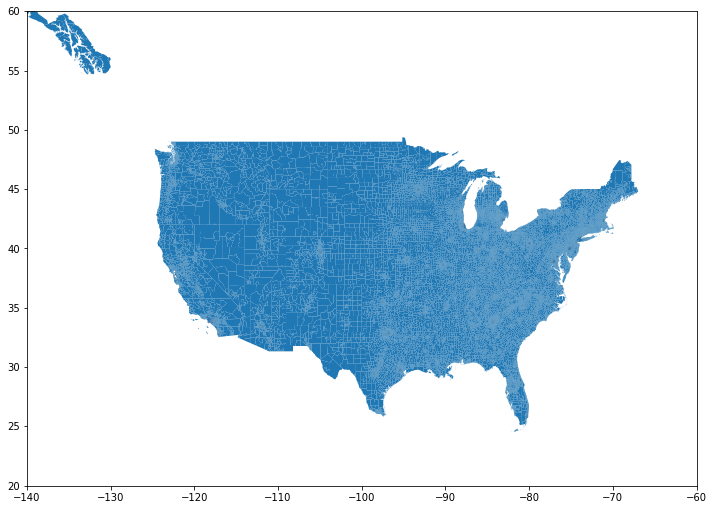

In [10]:
# have a look at the tract data in map form
ax = svi.plot(figsize=(12,12));
ax.set(xlim=(-140,-60), ylim=(20, 60)) # scale the figure with axes values

In [11]:
# get some metadata on the tracts
svi.info

<bound method DataFrame.info of        ST       STATE ST_ABBR STCNTY             COUNTY         FIPS  \
0      01     ALABAMA      AL  01015            Calhoun  01015981901   
1      01     ALABAMA      AL  01015            Calhoun  01015981902   
2      01     ALABAMA      AL  01015            Calhoun  01015981903   
3      01     ALABAMA      AL  01097             Mobile  01097003605   
4      01     ALABAMA      AL  01097             Mobile  01097990000   
...    ..         ...     ...    ...                ...          ...   
72832  51    VIRGINIA      VA  51003          Albemarle  51003010903   
72833  51    VIRGINIA      VA  51121         Montgomery  51121020202   
72834  51    VIRGINIA      VA  51700  Newport News City  51700030100   
72835  53  WASHINGTON      WA  53033               King  53033005302   
72836  53  WASHINGTON      WA  53077             Yakima  53077000100   

                                               LOCATION  AREA_SQMI  E_TOTPOP  \
0         Census Tract 

In [12]:
# get crs from data
svi.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [13]:
# read in cdps shapefile
cdps = gpd.read_file(r'C:\NewMapsPlus\Map698\us-communities-fire\notebooks\data\cdps.shp')

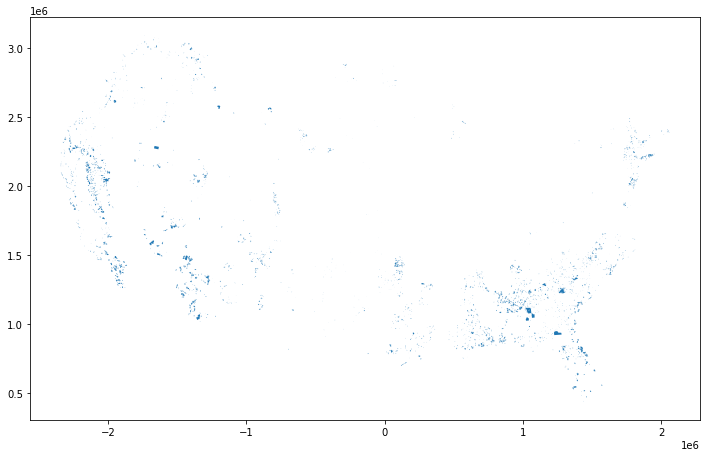

In [14]:
# look at the cdps
ax = cdps.plot()

In [15]:
# get cdp crs
cdps.crs

<Projected CRS: PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["Nor ...>
Name: NAD_1983_Albers
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Project Data Frames to same CRS for Overlay

In [16]:
# get the svi CRS again
print(svi.crs)

epsg:4269


In [17]:
# et the cdps CRS again
print(cdps.crs)

PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


#### Project both dataframes to equidistant conic projection since we'll be doing some overlays and weighting the results spatially

In [18]:
# set a variable with parameters for USA Contiguous Equidistant
project_params  = '+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

# reproject and assign to new variables
cdps_ec = cdps.to_crs(project_params)
svi_ec = svi.to_crs(project_params)

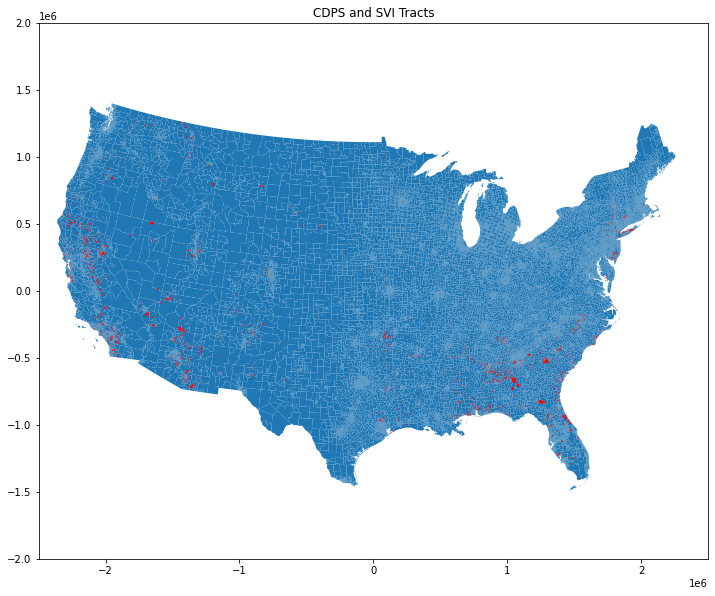

In [19]:
# overlay reprojected cdps on reprojected svis
fig, ax = plt.subplots()

svi_ec.plot(ax=ax, zorder=1);
cdps_ec.plot(ax=ax, color='red', zorder=2);

ax.set(title='CDPS and SVI Tracts')
ax.set(xlim=(-2500000, 2500000), ylim=(-2000000, 2000000));

### Intersect Tracts and CDPs
Use geopandas overlay method to intersect polygon dataframes

In [20]:
# input re-projected dataframes using intersection as method of overlay
cdps_svi_int = gpd.overlay(svi_ec, cdps_ec, how='intersection')

C:\miniconda3\envs\us-communities-fire\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 197 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  


In [21]:
# inspect the output and show all columns
pd.set_option("display.max_columns", None)

cdps_svi_int.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Shape_STAr,Shape_STLe,STATEFP_x,PLACEFP_x,PLACENS_x,AFFGEOID_x,GEOID,NAME_x,NAMELSAD_x,STUSPS_x,STATE_NAME,LSAD_x,ALAND_x,AWATER_x,Acres_x,AFFGEOID_y,ALAND_y,AWATER_y,Acres_y,LSAD_y,NAME_y,NAMELSAD_y,PLACEFP_y,PLACENS_y,STATEFP_y,STATE_NA_1,STUSPS_y,majority,geometry
0,01,ALABAMA,AL,01015,Calhoun,01015981903,"Census Tract 9819.03, Calhoun County, Alabama",13.926276,0,12,0,12,0,12,0,12,0,12,-999,-999,0,12,0,12,0,12,0,12,0,17.0,0,17.0,0,48.0,0,17.0,0,12,0,17.0,0,12,0,12,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,0,12,-999.0,-999.0,0,0.003508,0.330164,01,01852,02403101,1600000US0101852,0101852,Anniston,Anniston city,AL,Alabama,25,118685613,180468,29363.026855,1600000US0101852,118685613,180468,29363.026855,25,Anniston,Anniston city,01852,02403101,01,Alabama,AL,3.0,"MULTIPOLYGON (((944379.380 -539001.287, 944531..."
1,01,ALABAMA,AL,01015,Calhoun,01015000200,"Census Tract 2, Calhoun County, Alabama",2.624693,2554,360,1606,86,1242,162,406,211,123,76,20388,2897,259,132,556,161,359,154,768,230,118,84.9,1474,392.7,0,48.0,171,113.6,0,12,0,17.0,144,83,0,12,15.9,7.3,10.6,6.0,20388.0,2897.0,12.9,6.1,21.8,6.8,14.1,5.7,30.1,8.7,9.5,6.7,57.7,13.0,0.0,1.9,10.6,7.1,0.0,2.0,0.0,1.4,11.6,6.5,0.0,0.5,0.6309,0.8643,0.7944,0.6119,2.9015,0.7799,0.8392,0.0944,0.9901,0.6089,2.5326,0.8169,0.7311,0.0000,0.7311,0.3568,0.6597,0.0000,0.0000,0.7656,0.0000,1.4253,0.1625,7.5905,0.5622,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,347,168,13.6,6.0,3900,0.000660,0.135368,01,01852,02403101,1600000US0101852,0101852,Anniston,Anniston city,AL,Alabama,25,118685613,180468,29363.026855,1600000US0101852,118685613,180468,29363.026855,25,Anniston,Anniston city,01852,02403101,01,Alabama,AL,3.0,"POLYGON ((940338.282 -538071.843, 940605.753 -..."
2,01,ALABAMA,AL,01015,Calhoun,01015000300,"Census Tract 3, Calhoun County, Alabama",1.011936,2498,298,1602,86,1218,140,1011,276,174,103,18384,4015,487,128,326,64,647,159,787,172,226,94.9,2027,334.1,0,48.0,95,46.6,0,12,0,17.0,191,73,40,86,40.5,10.5,17.1,9.7,18384.0,4015.0,28.2,7.0,13.1,2.8,25.9,5.6,31.6,5.7,18.6,7.5,81.1,9.2,0.0,2.1,5.9,2.9,0.0,2.0,0.0,1.4,15.7,5.6,1.6,3.4,0.9565,0.9666,0.8530,0.9095,3.6856,0.9667,0.3684,0.7401,0.9932,0.9144,3.0161,0.9727,0.8571,0.0000,0.8571,0.4288,0.5426,0.0000,0.0000,0.8405,0.7502,2.1333,0.4156,9.6921,0.8439,1,1,0,1,3,0,0,1,1,2,0,0,0,0,0,0,0,0,0,5,334,118,13.4,4.6,3181,0.000258,0.070569,01,01852,02403101,1600000US0101852,0101852,Anniston,Anni

In [22]:
# get info about output
cdps_svi_int.info

<bound method DataFrame.info of       ST       STATE ST_ABBR STCNTY    COUNTY         FIPS  \
0     01     ALABAMA      AL  01015   Calhoun  01015981903   
1     01     ALABAMA      AL  01015   Calhoun  01015000200   
2     01     ALABAMA      AL  01015   Calhoun  01015000300   
3     01     ALABAMA      AL  01015   Calhoun  01015000900   
4     01     ALABAMA      AL  01015   Calhoun  01015001000   
...   ..         ...     ...    ...       ...          ...   
7667  49        UTAH      UT  49009   Daggett  49009960100   
7668  53  WASHINGTON      WA  53077    Yakima  53077940003   
7669  04     ARIZONA      AZ  04007      Gila  04007940400   
7670  06  CALIFORNIA      CA  06053  Monterey  06053011400   
7671  06  CALIFORNIA      CA  06053  Monterey  06053011400   

                                             LOCATION    AREA_SQMI  E_TOTPOP  \
0       Census Tract 9819.03, Calhoun County, Alabama    13.926276         0   
1             Census Tract 2, Calhoun County, Alabama     2.624

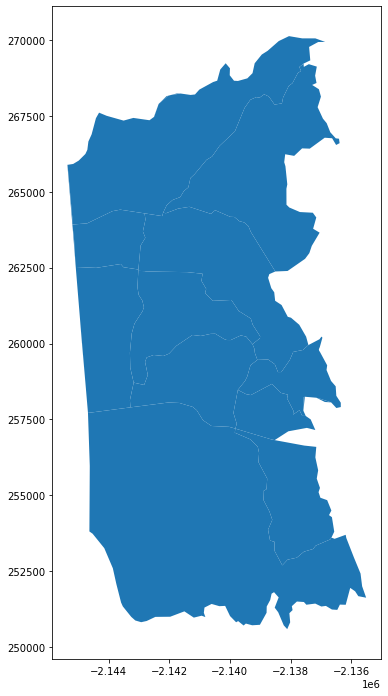

In [23]:
# plot intersection results in the CDP of El Dorado Hills, CA
eldhills = cdps_svi_int.loc[cdps_svi_int['NAME_x'] == 'El Dorado Hills']

eldhills.plot();

In [24]:
# keep useful columns and add to new dataframe
cdps_svis = cdps_svi_int.filter(['ST','STATE', 'ST_ABBR','STCNTY','COUNTY', 'FIPS','LOCATION', 'AREA_SQMI', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES', 
                                'AFFGEOID_x', 'GEOID', 'NAME_x','NAMELSAD_x', 'STUSPS_x', 'STATE_NAME','Acres_x','majority','geometry' ])

In [25]:
# inspect the dataframe and show all columns
pd.set_option("display.max_columns", None)

cdps_svis.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,AFFGEOID_x,GEOID,NAME_x,NAMELSAD_x,STUSPS_x,STATE_NAME,Acres_x,majority,geometry
0,01,ALABAMA,AL,01015,Calhoun,01015981903,"Census Tract 9819.03, Calhoun County, Alabama",13.926276,-999.0000,-999.0000,-999.0000,-999.0000,-999.0000,1600000US0101852,0101852,Anniston,Anniston city,AL,Alabama,29363.026855,3.0,"MULTIPOLYGON (((944379.380 -539001.287, 944531..."
1,01,ALABAMA,AL,01015,Calhoun,01015000200,"Census Tract 2, Calhoun County, Alabama",2.624693,0.7799,0.8169,0.3568,0.1625,0.5622,1600000US0101852,0101852,Anniston,Anniston city,AL,Alabama,29363.026855,3.0,"POLYGON ((940338.282 -538071.843, 940605.753 -..."
2,01,ALABAMA,AL,01015,Calhoun,01015000300,"Census Tract 3, Calhoun County, Alabama",1.011936,0.9667,0.9727,0.4288,0.4156,0.8439,1600000US0101852,0101852,Anniston,Anniston city,AL,Alabama,29363.026855,3.0,"POLYGON ((939294.054 -537838.280, 939408.130 -..."
3,01,ALABAMA,AL,01015,Calhoun,01015000900,"Census Tract 9, Calhoun County, Alabama",4.677727,0.5055,0.9057,0.2248,0.3705,0.5054,1600000US0101852,0101852,Anniston,Anniston city,AL,Alabama,29363.026855,3.0,"MULTIPOLYGON (((946730.589 -539546.259, 946730..."
4,01,ALABAMA,AL,01015,Calhoun,01015001000,"Census Tract 10, Calhoun County, Alabama",6.438867,0.4721,0.6984,0.5964,0.3310,0.5074,1600000US0101852,0101852,Anniston,Anniston city,AL,Alabama,29363.026855,3.0,"POLYGON ((940843.383 -544243.977, 940848.391 -..."


In [26]:
# write the new dataframe to a shapefile
cdps_svis.to_file(r'C:\NewMapsPlus\Map698\us-communities-fire\data\cdps_svis.shp')